In [19]:
import os
import sys
import csv
import json
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [20]:
def extract_info(s:str)->dict:
    info = dict()
    time_pattern = re.compile(r'Time\[(\d+\.\d+)ms\]')
    id_pattern = re.compile(r'Job\[\s*(\d+)\]')


    info["job_id"] = int(re.findall("\[(.*?)\]",s,re.I|re.M)[1])
    info["time"] = float(re.findall("\[(.*?)\]",s,re.I|re.M)[0].split()[0])
    info["event"] = s.split(",")[1].strip()

    return info

In [21]:
def get_job_num(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    
    lines = [extract_info(line) for line in lines if line.startswith("DEBUG")]
    return int(len(lines) / 3) , lines

In [22]:
def get_job_event_time(job_id:int,event:str,lines:list,scale_factor):
    for line in lines:
        if line["job_id"] == job_id and line["event"] == event:
            return float(line["time"]) * scale_factor / 1000
    return None

In [23]:
def main(sched_name:str, scale_factor):
    filename = sched_name + ".csv"
    job_num, lines = get_job_num(filename)
    #print(lines)
    jobs = dict()
    jct_sum = list()
    for job_id in range(job_num):
        arrive_time = get_job_event_time(job_id,"ARRIVE",lines,scale_factor)
        #print(arrive_time)
        place_time  = get_job_event_time(job_id,"START", lines,scale_factor)
        end_time    = get_job_event_time(job_id,"END",   lines,scale_factor)
        jobs[job_id] = {
            "arrive_time":arrive_time,
            "place_time":place_time,
            "end_time":end_time,
            "pend_time":place_time - arrive_time,
            "exec_time":end_time - place_time
        }
        #print(job_id,"%.2f" % (end_time - arrive_time))
        jct_sum.append(end_time - arrive_time)
        ave_jct = np.mean(np.array((jct_sum)))
    tmp = [float("%.2f" % i) for i in jct_sum]
    print("JCT", tmp)
    print("*" * 40)
    print("Schedule name: %s" % sched_name)
    print("Ave JCT: %.2f" % (sum(jct_sum) / job_num))
    #print(jct_sum)
    # print("99%%-th JCT: %.2f" % np.percentile(jct_sum, 99))
    print("95%%-th JCT: %.2f" % np.percentile(jct_sum, 95))
    print("Makespan: %.2f" % (float(lines[-1]["time"] - lines[0]["time"]) * scale_factor / 1000))
    return jobs, sum(jct_sum) / job_num, np.percentile(jct_sum, 95), (lines[-1]["time"] - lines[0]["time"])

JCT [79.6, 59.49, 124.71, 46.96, 176.71, 101.24, 71.6, 109.68, 78.64, 59.28, 84.29, 36.65, 124.25, 62.13, 153.21, 155.48, 53.95, 42.1, 130.99, 50.22, 19.77, 302.32, 169.74, 78.64, 93.6, 78.64, 46.96, 122.41, 17.98, 118.47, 25.48, 178.21, 27.84, 46.96, 184.61, 131.62, 49.02, 78.64, 36.52, 21.53, 259.21, 260.15, 93.71, 385.84, 21.53, 57.58, 176.35, 59.36, 22.56, 385.84, 170.28, 60.99, 63.59, 98.44, 75.18, 100.33, 86.49, 46.96, 82.77, 59.15]
****************************************
Schedule name: fifo-consolidate
Ave JCT: 103.27
95%-th JCT: 262.26
Makespan: 2117.17
JCT [79.6, 59.49, 124.71, 46.96, 176.71, 101.24, 71.6, 109.68, 78.64, 59.28, 84.29, 36.65, 124.25, 62.13, 153.21, 155.48, 53.95, 42.1, 130.99, 50.22, 19.77, 302.32, 169.74, 78.64, 93.6, 78.64, 46.96, 122.41, 17.98, 118.47, 25.48, 178.21, 27.84, 46.96, 184.61, 131.62, 49.02, 78.64, 36.52, 21.53, 259.21, 260.15, 93.71, 385.84, 21.53, 57.58, 178.99, 59.36, 22.56, 385.84, 171.11, 60.99, 63.59, 104.38, 68.96, 97.89, 79.58, 47.78, 82

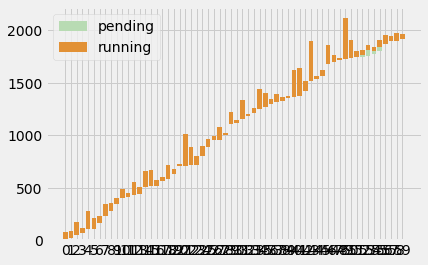

In [24]:
sched_list = [
    "fifo-consolidate",
    "smallest-consolidate",
    "time-shortest-consolidate",
    "gputime-shortest-consolidate",
]
jct_dict = dict()
jct_dict_95 = dict()
makespan_list = dict()
scale_factor = 40
for sched in sched_list:
    jobs_info, ave_jct, jct_95, makespan = main(sched,scale_factor)
    jct_dict[sched] = ave_jct
    jct_dict_95[sched] = jct_95
    makespan_list[sched] = makespan
    #continue
    arrive_list = [v["arrive_time"] for k,v in jobs_info.items()]
    pend_list   = [v["pend_time"]   for k,v in jobs_info.items()]
    exec_list   = [v["exec_time"]   for k,v in jobs_info.items()]
    place_list  = [v["place_time"]  for k,v in jobs_info.items()]
    plt.cla()
    plt.style.use("fivethirtyeight")
    plt.bar(range(len(jobs_info)), pend_list, bottom=arrive_list, color = "#B8DBB3", label = "pending")
    plt.bar(range(len(jobs_info)), exec_list, bottom=place_list,  color = "#E29135", label = "running")
    plt.xticks(range(len(jobs_info)))
    plt.legend()
    plt.savefig("%s.pdf" % sched, bbox_inches = "tight")

total = 0
if 0:
    plt.cla()
    plt.title("JCT comparision")
    plt.style.use("fivethirtyeight")
    plt.bar(range(len(jct_dict)),np.array(list(jct_dict.values())) / min(jct_dict.values()))
    plt.xlabel("Sched + Placer")
    plt.xticks(range(len(jct_dict)),[
        "jaca_future","jaca",
        "G&T-C","GPU-C","Time-C","Arr-C",
        "G&T-LB","GPU-LB","Time-LB","Arr-LB",
    ],rotation = 0, fontsize = 8)
    
    plt.savefig("jct/jct.pdf", bbox_inches = "tight")
if 0:
    plt.cla()
    plt.title("JCT-95th comparision")
    plt.style.use("fivethirtyeight")
    plt.bar(range(len(jct_dict_95)),np.array(list(jct_dict_95.values())) / min(jct_dict_95.values()))
    plt.xlabel("Sched + Placer")
    plt.xticks(range(len(jct_dict_95)),[
        "jaca_future","jaca",
        "G&T-C","GPU-C","Time-C","Arr-C",
        "G&T-LB","GPU-LB","Time-LB","Arr-LB",
    ],rotation = 0, fontsize = 5)
    plt.savefig("jct/jct-95th.pdf", bbox_inches = "tight")
if 0:
    plt.cla()
    plt.title("Makespan comparision")
    plt.style.use("fivethirtyeight")
    plt.bar(range(len(makespan_list)),np.array(list(makespan_list.values())) / min(makespan_list.values()))
    plt.xlabel("Sched + Placer")
    plt.xticks(range(len(makespan_list)),[
        "jaca_future","jaca",
        "G&T-C","GPU-C","Time-C","Arr-C",
        "G&T-LB","GPU-LB","Time-LB","Arr-LB",
    ],rotation = 0, fontsize = 5)
    plt.savefig("jct/makespan.pdf", bbox_inches = "tight")